# ZKsyn data exploration - Fees and gas

#### [Maria Silva](https://github.com/misilva73), June 2024

## Import packages

In [1]:
import os
import polars as pl
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

Note that these are support functions defined in the `src` folder:

In [3]:
from plot_utils import get_plotly_layout, colors, update_plotly_layout_in_place

width, height = 800, 450

##  Load Polars DataFrames

In [4]:
# Set directory paths
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots", "gas_and_fees_example"))

# Set block limits
block_start = 56_1367 # starting on April 1st to ignore weird blocks during era launch
block_end = 29_710_983

In [5]:
# Load blocks data
blocks_path = os.path.join(data_dir, "blocks", "blocks_*.parquet")
blocks_lazy_df = (
    pl.scan_parquet(blocks_path)
    .filter(pl.col("number").is_between(block_start, block_end))
    .with_columns(pl.from_epoch("timestamp", time_unit="s"))
    .with_columns(pl.col("timestamp").cast(pl.Date).alias("day"))
    .sort("timestamp")
)
blocks_lazy_df.schema

OrderedDict([('hash', String),
             ('parentHash', String),
             ('sha3Uncles', String),
             ('miner', String),
             ('stateRoot', String),
             ('transactionsRoot', String),
             ('receiptsRoot', String),
             ('number', Int64),
             ('l1BatchNumber', String),
             ('gasUsed', Int64),
             ('gasLimit', Int64),
             ('baseFeePerGas', Int64),
             ('extraData', String),
             ('logsBloom', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('l1BatchTimestamp', String),
             ('difficulty', Int64),
             ('totalDifficulty', Int64),
             ('sealFields', List(Null)),
             ('uncles', List(Null)),
             ('size', Int64),
             ('mixHash', String),
             ('nonce', String),
             ('day', Date)])

In [6]:
# Create temp df to join timestamps and date
temp_blocks_df = (
    blocks_lazy_df.select(pl.col("number"), pl.col("timestamp"), pl.col("day"))
)

# Load transaction data
txs_path = os.path.join(data_dir, "tx_receipts", "tx_receipts_*.parquet")
txs_lazy_df = (
    pl.scan_parquet(txs_path)
    .filter(pl.col("blockNumber").is_between(block_start, block_end))
    .join(temp_blocks_df, left_on="blockNumber", right_on="number")
    .sort("timestamp")
)
txs_lazy_df.schema

OrderedDict([('blockHash', String),
             ('blockNumber', Int64),
             ('contractAddress', String),
             ('cumulativeGasUsed', Int64),
             ('effectiveGasPrice', Int64),
             ('from', String),
             ('gasUsed', Int64),
             ('l1BatchNumber', String),
             ('l1BatchTxIndex', String),
             ('logsBloom', String),
             ('root', String),
             ('status', Int64),
             ('to', String),
             ('transactionHash', String),
             ('transactionIndex', Int64),
             ('type', Int64),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('day', Date)])

##  Process Polars DataFrames

In [7]:
# Compute daily aggregated data for blocks
block_data_per_day_df = (
    blocks_lazy_df
    .group_by("day")
    .agg(
        pl.col("gasUsed").mean().alias("avg_gas_used_block"),
        pl.col("gasUsed").sum().alias("total_gas_used_day"),
        pl.col("gasLimit").sum().alias("total_gas_limit_day"),
        (pl.col("gasUsed").sum()/pl.col("gasLimit").sum()).alias("gas_utilization_rate_day"),
        pl.col("baseFeePerGas").mean().alias("avg_base_fee_price_block")
    )
    .sort("day")
    .collect(streaming=True)
    .to_pandas()
)
block_data_per_day_df.head()

,day,avg_gas_used_block,total_gas_used_day,total_gas_limit_day,gas_utilization_rate_day,avg_base_fee_price_block
0,2023-04-01,5.113545e+06,291185722800,244572617646480,0.001191,250000000.0
1,2023-04-02,4.577601e+06,315039633258,295588239176490,0.001066,250000000.0
2,2023-04-03,5.901565e+06,413428260014,300879638883930,0.001374,250000000.0
3,2023-04-04,5.624768e+06,387569003304,295940426494680,0.001310,250000000.0
4,2023-04-05,6.048327e+06,422415145071,299960515882800,0.001408,250000000.0


In [8]:
# Compute daily aggregated data for transactions

tx_data_per_day_df = (
    txs_lazy_df
    .group_by("day")
    .agg(
        pl.col("gasUsed").mean().alias("avg_gas_used_tx"),
        pl.col("gasUsed").sum().alias("total_gas_used_day"),
        pl.col("effectiveGasPrice").mean().alias("avg_gas_price_tx"),
        pl.col("transactionHash").count().alias("tx_count")
    )
    .sort("day")
    .collect(streaming=True)
    .to_pandas()
)
tx_data_per_day_df["avg_gas_price_tx_gwei"] = tx_data_per_day_df["avg_gas_price_tx"]*0.000000001
tx_data_per_day_df["Month"] = tx_data_per_day_df["day"].dt.month_name() + " " + tx_data_per_day_df["day"].dt.year.astype("str")
tx_data_per_day_df.head()

,day,avg_gas_used_tx,total_gas_used_day,avg_gas_price_tx,tx_count,avg_gas_price_tx_gwei,Month
0,2023-04-01,8.389198e+05,291185722800,2.720168e+08,347096,0.272017,April 2023
1,2023-04-02,7.853745e+05,315039633258,2.700304e+08,401133,0.270030,April 2023
2,2023-04-03,9.921389e+05,413428260014,2.667310e+08,416704,0.266731,April 2023
3,2023-04-04,1.051308e+06,387569003304,2.670195e+08,368654,0.267020,April 2023
4,2023-04-05,1.376129e+06,422415145071,2.668927e+08,306959,0.266893,April 2023


## Gas usage analysis

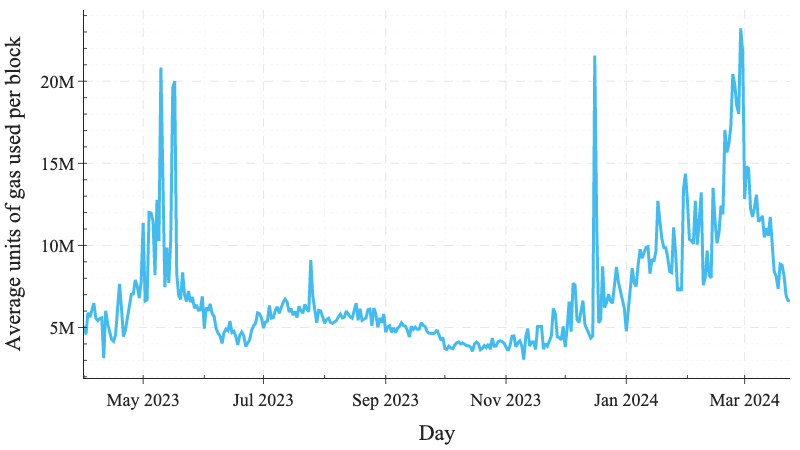

In [9]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df['day'], 
    y=block_data_per_day_df['avg_gas_used_block'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Average units of gas used per block",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-gas-used-block.pdf'))
fig.show('png')

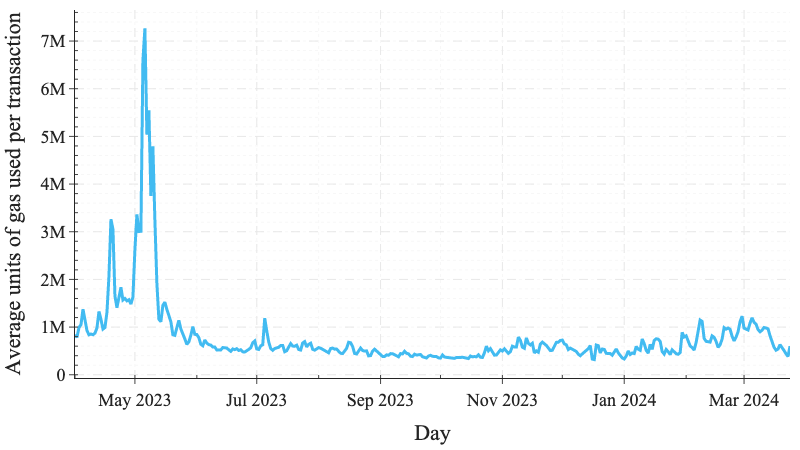

In [10]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['day'], 
    y=tx_data_per_day_df['avg_gas_used_tx'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Average units of gas used per transaction",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-gas-used-tx.pdf'))
fig.show('png')

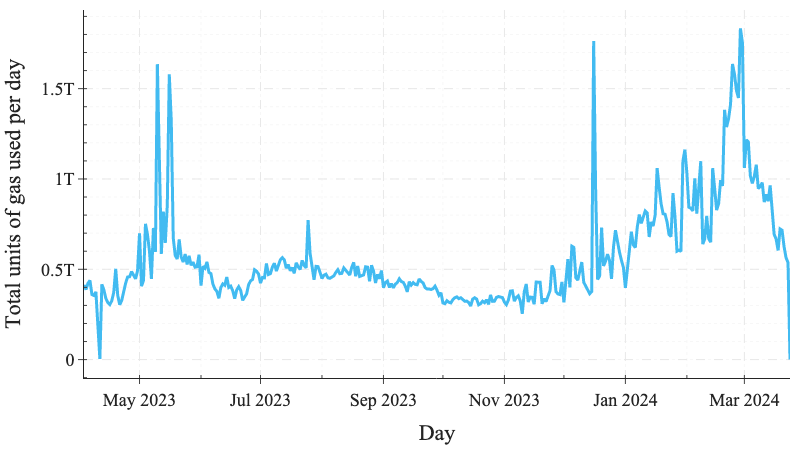

In [11]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:]['day'], 
    y=block_data_per_day_df.iloc[2:]['total_gas_used_day'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day",
                  yaxis_title="Total units of gas used per day", 
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'daily-total-gas-used.pdf'))
fig.show('png')

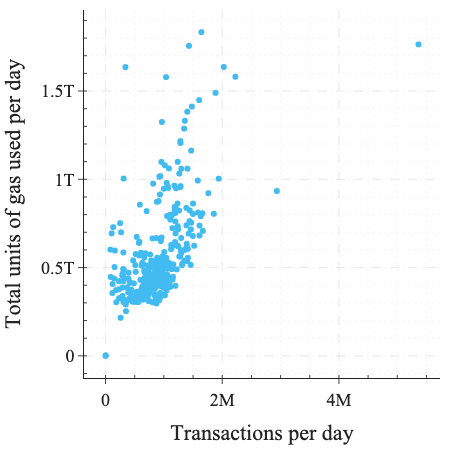

In [12]:
fig = go.Figure(layout=get_plotly_layout(width=height, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['tx_count'], 
    y=tx_data_per_day_df['total_gas_used_day'], 
    line=dict(color=colors['blue'], width=3), mode='markers'))

fig.update_layout(xaxis_title="Transactions per day", 
                  yaxis_title="Total units of gas used per day",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'total-gas-used-vs-tx-count.pdf'))
fig.show('png')

## Gas fees analysis

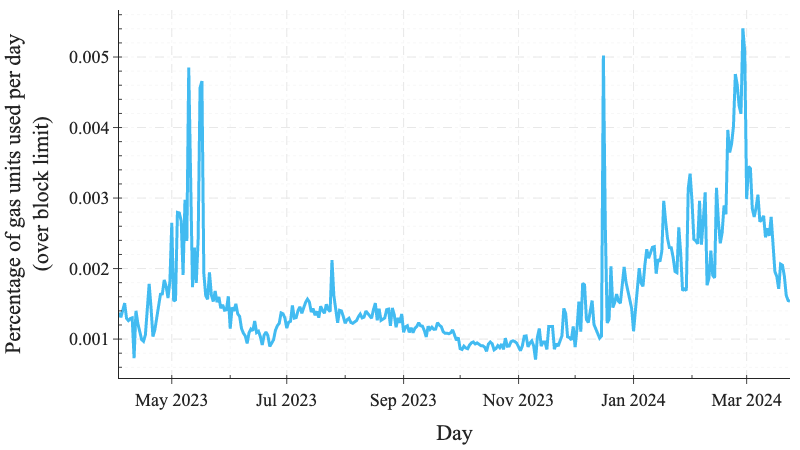

In [13]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:]['day'], 
    y=block_data_per_day_df.iloc[2:]['gas_utilization_rate_day'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Percentage of gas units used per day<br>(over block limit)",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'gas-utilization-rate-day.pdf'))
fig.show('png')

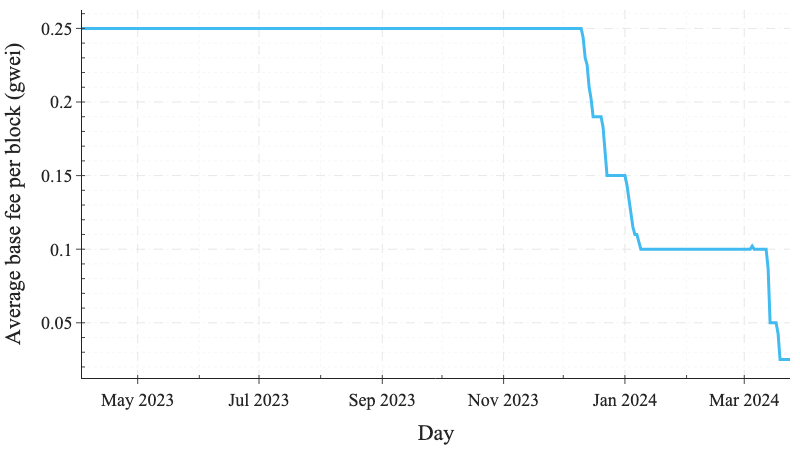

In [14]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:]['day'], 
    y=block_data_per_day_df.iloc[2:]['avg_base_fee_price_block']*0.000000001, 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day",
                  yaxis_title="Average base fee per block (gwei)",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-base-fee-price-day.pdf'))
fig.show('png')

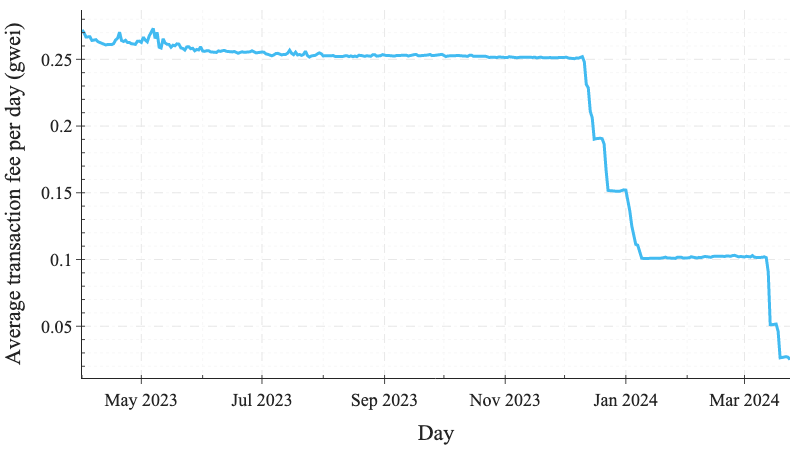

In [15]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['day'], 
    y=tx_data_per_day_df['avg_gas_price_tx_gwei'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Average transaction fee per day (gwei)",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-tx-fee-day.pdf'))
fig.show('png')

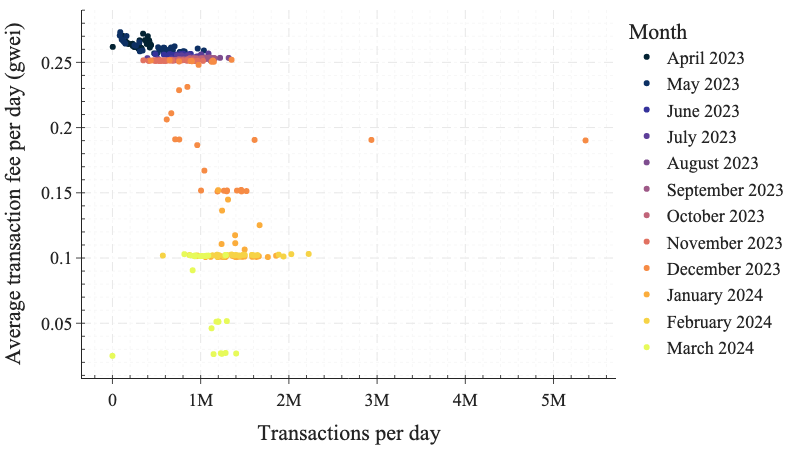

In [16]:
fig = px.scatter(
    tx_data_per_day_df, 
    x="tx_count", 
    y="avg_gas_price_tx_gwei", 
    color="Month",
    color_discrete_sequence=px.colors.sequential.thermal)

update_plotly_layout_in_place(fig=fig, width=width, height=height)

fig.update_layout(xaxis_title="Transactions per day",
                  yaxis_title="Average transaction fee per day (gwei)")

fig.write_image(os.path.join(plots_dir,'avg-tx-fee-vs-tx-count.pdf'))
fig.show('png')

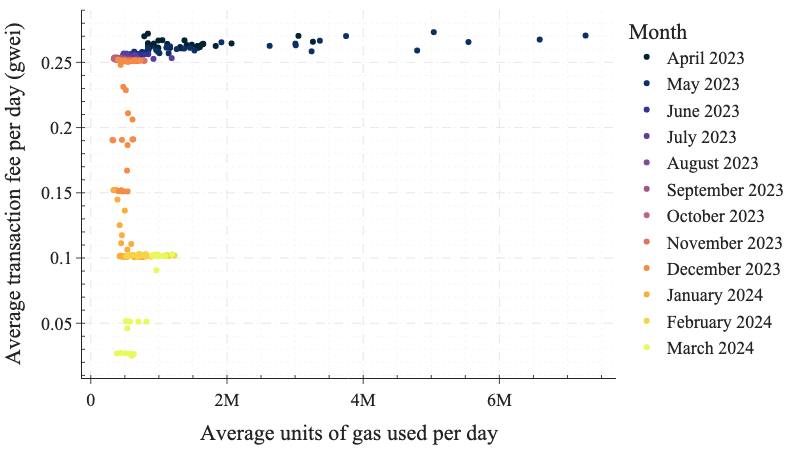

In [17]:
tx_data_per_day_df["Month"] = tx_data_per_day_df["day"].dt.month_name() + " " + tx_data_per_day_df["day"].dt.year.astype("str")

fig = px.scatter(
    tx_data_per_day_df, 
    x="avg_gas_used_tx", 
    y="avg_gas_price_tx_gwei", 
    color="Month",
    color_discrete_sequence=px.colors.sequential.thermal)

update_plotly_layout_in_place(fig=fig, width=width, height=height)

fig.update_layout(xaxis_title="Average units of gas used per day",
                  yaxis_title="Average transaction fee per day (gwei)")

fig.write_image(os.path.join(plots_dir,'avg-tx-fee-vs-avg-gas-usage.pdf'))
fig.show('png')